In [1]:
%load_ext tensorboard

# Install Packages
import datetime

# for path handling
import os
import pathlib

# for loading images into numpy
import imageio

import numpy as np
import pandas as pd

# for greyscale conversion
from skimage.color import rgb2gray

# for plotting
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from keras.callbacks import CSVLogger


In [2]:
# reset session
keras.backend.clear_session()
tf.__version__

'2.6.2'

# Reading Data and Data Preparation

https://www.tensorflow.org/tutorials/load_data/images

In [3]:
# get image resolution
def get_image_resolution(image_path):
    image = imageio.imread(image_path)
    return image.shape


In [4]:
# check resolution of image
images = list(pathlib.Path("./images/training/fully/").glob("*.jpeg"))
image_resolution = get_image_resolution(images[0])

print(f"Image resolution: {image_resolution}")
# because they are thumbnails all images have the same resolution

Image resolution: (229, 400, 3)


In [5]:
# loading data with keras utility

path_to_data = "./images/training"

batch_size = 32
# get image dimensions
img_height, img_width = image_resolution[:2]

train_data: tf.data.Dataset = keras.utils.image_dataset_from_directory(
    path_to_data,
    labels="inferred",
    seed=1,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="training"
)

validation_data: tf.data.Dataset = keras.utils.image_dataset_from_directory(
    path_to_data,
    labels='inferred',
    seed=1,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation"
)

# check if data was read correctly
class_names = train_data.class_names
print(f"Class names: {class_names}")


Found 274 files belonging to 2 classes.
Using 220 files for training.
Found 274 files belonging to 2 classes.
Using 54 files for validation.
Class names: ['fully', 'hardtail']


# Dataexploration

Imageshape: (229, 400, 3) Labels: 1
Imageshape: (229, 400, 3) Labels: 0
Imageshape: (229, 400, 3) Labels: 1
Imageshape: (229, 400, 3) Labels: 0
Imageshape: (229, 400, 3) Labels: 0
Imageshape: (229, 400, 3) Labels: 0
Imageshape: (229, 400, 3) Labels: 0
Imageshape: (229, 400, 3) Labels: 1
Imageshape: (229, 400, 3) Labels: 1


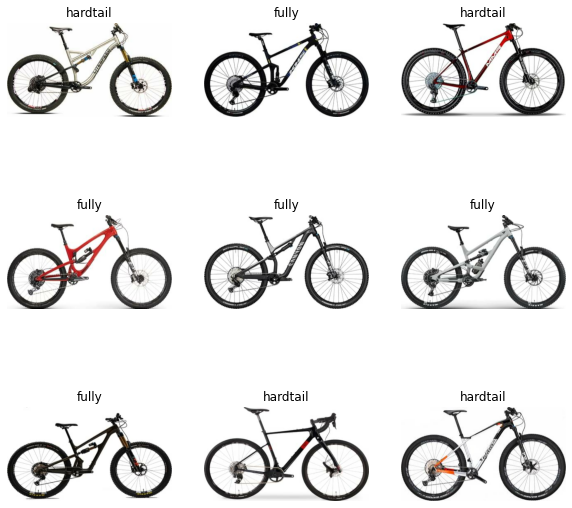

In [6]:
# plot some images
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        print(f"Imageshape: {images[i].shape} Labels: {labels[i]}")
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [7]:
# print dimmensions
# 32 => batch of 32 images
# 229 => height of image
# 400 => width of image
# 3 => RGB
for image_batch, labels_batch in train_data:
  print(f"Image Batch: {image_batch.shape},  Labels Batch: {labels_batch}")


Image Batch: (32, 229, 400, 3),  Labels Batch: [1 0 0 0 0 0 1 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 0 0 1 0 1 1 1 1 0 1]
Image Batch: (32, 229, 400, 3),  Labels Batch: [1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 1 1 0 0 0]
Image Batch: (32, 229, 400, 3),  Labels Batch: [0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0 1 1 1 0 1 1 0]
Image Batch: (32, 229, 400, 3),  Labels Batch: [0 1 0 0 1 1 1 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1 0 0 1 1 0 1 0 0]
Image Batch: (32, 229, 400, 3),  Labels Batch: [0 1 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 0 1 0 0 1]
Image Batch: (32, 229, 400, 3),  Labels Batch: [1 0 0 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 0 0]
Image Batch: (28, 229, 400, 3),  Labels Batch: [0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 0]


# Dataprepatation

In [8]:
# normalization
normalization_layer = keras.layers.Rescaling(scale=1./255)

In [9]:
# greyscale conversion
greyscale_layer = keras.layers.Lambda(lambda img: tf.image.rgb_to_grayscale(img))

In [10]:
data_preparation_layer = keras.Sequential([
    greyscale_layer,
    normalization_layer,
], "data_preparation")


<Figure size 72x144 with 0 Axes>

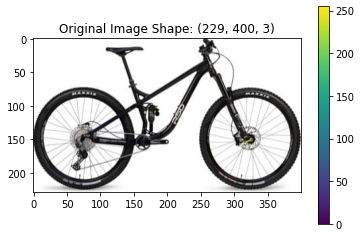

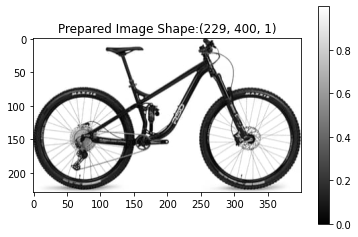

In [11]:
# test data preparation layer
plt.figure(figsize=(1, 2))
for images, _ in train_data.take(1):
    for i in range(1):
        prepared_images = data_preparation_layer(images)

        plt.figure()
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.colorbar()
        plt.grid(False)
        plt.title(f"Original Image Shape: {images[0].shape}")
        plt.show()

        plt.figure()
        plt.imshow(prepared_images[0], cmap="gray")
        plt.colorbar()
        plt.grid(False)
        plt.title(f"Prepared Image Shape:{prepared_images[0].shape}")
        plt.show()


In [12]:
# data augmentation
data_augmentation_layer = keras.Sequential([
    # flip random bikes left to right, so the AI will be able to process bikes facing in any direction
    keras.layers.RandomFlip("horizontal", seed=1)
], "data_augmentation")


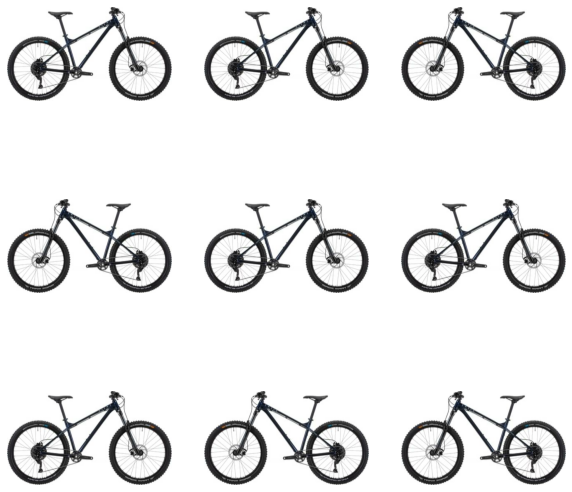

In [13]:
# visualize data augmentation
plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
  for i in range(9):
    augmented_images = data_augmentation_layer(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [14]:
# Performace tweaks

def prepare_ds_for_performance(data_set):
    data_set.cache().prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)
    return data_set

train_data = prepare_ds_for_performance(train_data)
validation_data = prepare_ds_for_performance(validation_data)

In [15]:
num_classes = len(class_names)

models_path = "./models"
training_logs_path = "./training_logs"
checkpoints_path = "./checkpoints"

model = keras.Sequential([
    # Data preparation
    data_preparation_layer,

    # Data augmentation
    data_augmentation_layer,

    # Convolutional layers
    keras.layers.Conv2D(32, 3, activation='relu',
                        input_shape=(img_height, img_width, 1)),  # 1 for greyscale; 3 for RGB
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(num_classes)
], "bike_classifier")

model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)


In [16]:
epochs = 50

In [17]:
def create_path_if_not_exists(path):
    pathlib.Path(path).mkdir(parents=True, exist_ok=True)

In [29]:
# create required directories
create_path_if_not_exists(training_logs_path)
create_path_if_not_exists(checkpoints_path)

# save training logs
csv_logger = CSVLogger(
    f"{training_logs_path}/{model.name}.csv", separator=";", append=True)

# save the trained epochs
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"{checkpoints_path}/{model.name}_cp.ckpt"
)

# try load checkpoints
if tf.train.latest_checkpoint(checkpoints_path):
    model.load_weights(tf.train.latest_checkpoint(checkpoints_path))

# train model
history = model.fit(
    train_data,
    validation_data=validation_data,

    epochs=epochs,
    batch_size=batch_size,

    use_multiprocessing=True,
    workers=4,

    callbacks=[
        csv_logger,
        checkpoint_callback
    ]
)


Epoch 1/10
7/7 [==============================] - 12s 2s/step - loss: 0.0546 - accuracy: 0.9818 - val_loss: 0.0930 - val_accuracy: 0.9630
INFO:tensorflow:Assets written to: ./checkpoints/bike_classifier_cp.ckpt/assets
Epoch 2/10
7/7 [==============================] - 12s 2s/step - loss: 0.0383 - accuracy: 0.9909 - val_loss: 0.1312 - val_accuracy: 0.9815
INFO:tensorflow:Assets written to: ./checkpoints/bike_classifier_cp.ckpt/assets
Epoch 3/10
7/7 [==============================] - 13s 2s/step - loss: 0.0434 - accuracy: 0.9818 - val_loss: 0.1320 - val_accuracy: 0.9815
INFO:tensorflow:Assets written to: ./checkpoints/bike_classifier_cp.ckpt/assets
Epoch 4/10
7/7 [==============================] - 14s 2s/step - loss: 0.0397 - accuracy: 0.9909 - val_loss: 0.0633 - val_accuracy: 0.9815
INFO:tensorflow:Assets written to: ./checkpoints/bike_classifier_cp.ckpt/assets
Epoch 5/10
7/7 [==============================] - 13s 2s/step - loss: 0.0199 - accuracy: 0.9955 - val_loss: 0.0793 - val_accurac

In [19]:
def plot_scores():
    # read training log csv to dataframe
    training_logs_df = pd.read_csv(
        f"{training_logs_path}/{model.name}.csv",
        sep=";",
        header=0 # take headers from first row
    )

    acc = training_logs_df["accuracy"]
    val_acc = training_logs_df["val_accuracy"]

    loss = training_logs_df["loss"]
    val_loss = training_logs_df["val_loss"]

    # epochs shifted by 1
    epochs_range = list(range(1, training_logs_df["epoch"].count()+1))

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.yticks(np.arange(0, 1.1, 0.1))
    if len(epochs_range) < 20:
        plt.xticks(epochs_range)
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    # plt.yticks(np.arange(0, 1.1, 0.1))
    if len(epochs_range) < 20:
        plt.xticks(epochs_range)
    plt.title('Training and Validation Loss')
    plt.show()


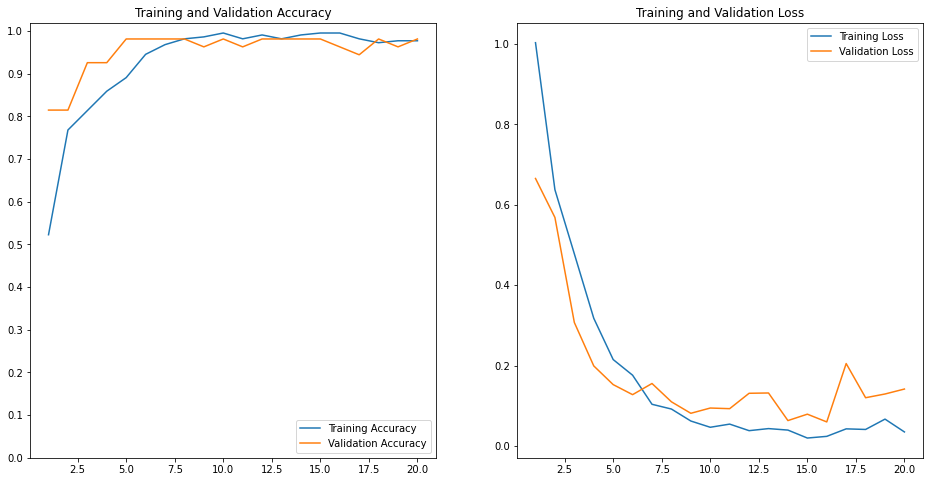

In [30]:
plot_scores()


In [31]:
def plot_recent_training_scores():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    # plt.yticks(np.arange(0, 1.1, 0.1))
    plt.title('Training and Validation Loss')
    plt.show()


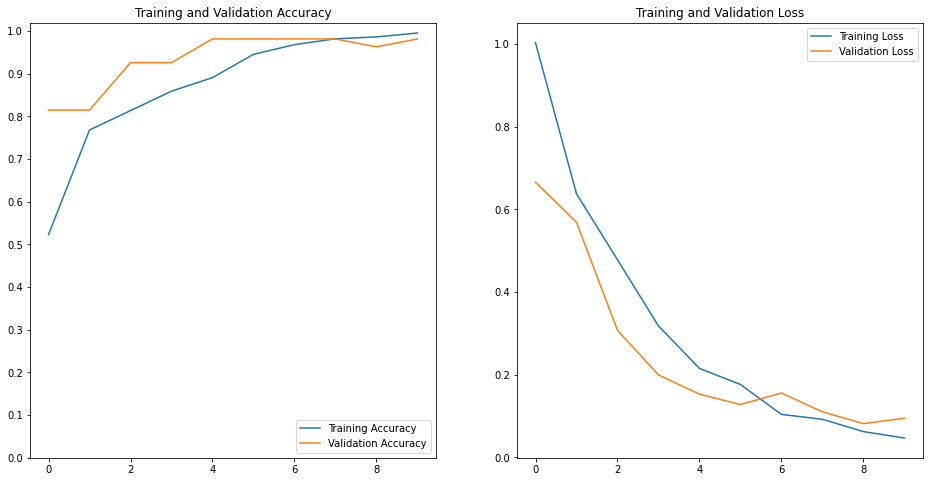

In [22]:
plot_recent_training_scores()

In [23]:
model.summary()


Model: "bike_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_preparation (Sequential (None, 229, 400, 1)       0         
_________________________________________________________________
data_augmentation (Sequentia (None, 229, 400, None)    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 227, 398, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 113, 199, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 111, 197, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 98, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 96, 32)    

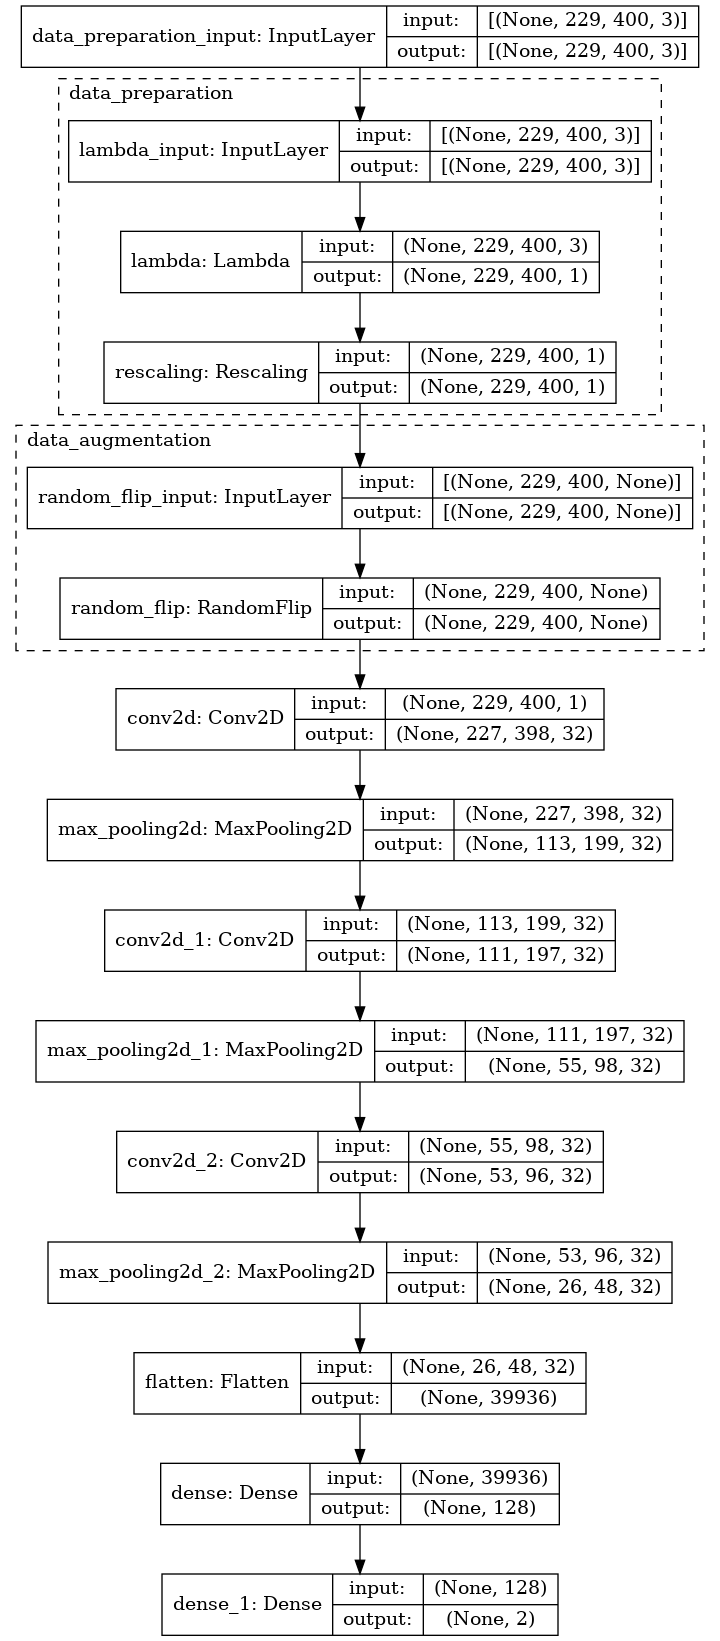

In [24]:
# plot model
keras.utils.plot_model(model,
                       show_shapes=True,
                       expand_nested=True,
                    #    show_layer_names=True,
                       )


In [25]:
# evaluation
# TRAIN
for image_batch, labels_batch in train_data.take(1):
    train_loss, train_acc = model.evaluate(
        image_batch, labels_batch, verbose=2)
    print(
        f"TRAIN: Loss: {round(train_loss,3)},  Accuracy: {round(train_acc,2)}")


# VALIDATION
for image_batch, labels_batch in validation_data.take(1):
    validation_loss, validation_acc = model.evaluate(
        image_batch, labels_batch, verbose=2)
    print(
        f"VALIDATION: Loss: {round(validation_loss,3)},  Accuracy: {round(validation_acc,2)}")


1/1 - 0s - loss: 0.1535 - accuracy: 0.9688
TRAIN: Loss: 0.153,  Accuracy: 0.97
1/1 - 0s - loss: 0.1520 - accuracy: 0.9688
VALIDATION: Loss: 0.152,  Accuracy: 0.97


# Predicting new Data

In [26]:
# predict images function
def predict_image(image_path, mirrored=False):
    img = keras.utils.load_img(image_path, target_size=(img_height, img_width))

    if mirrored == True:
        img = tf.image.flip_left_right(img)

    img_array = keras.utils.img_to_array(img)
    # create a batch of size 1
    img_array = tf.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    plt.imshow(img)
    plt.axis("off")

    color = ""

    probability = round(100*np.max(score), 2)

    if probability > 80:
        color = "green"
    elif probability > 60:
        color = "orange"
    else:
        color = "red"

    plt.title(
        f"{image_path.name} - {class_names[np.argmax(score)].upper()} {probability}%", color=color)
    plt.show()
    return predictions

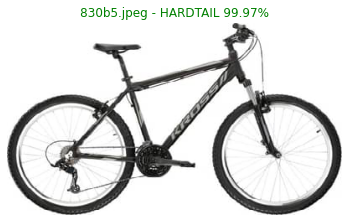

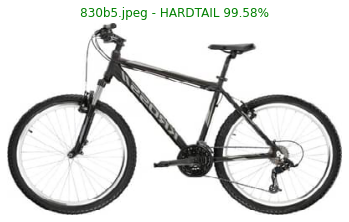

In [27]:
paths_to_test_images = list(pathlib.Path("./images/test/").glob("*.jpeg"))

rnd_image = np.random.choice(paths_to_test_images)

predict_image(rnd_image);
predict_image(rnd_image, mirrored=True);


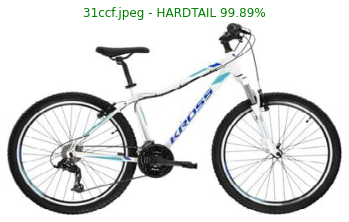

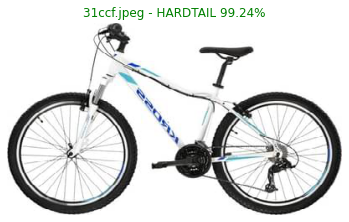

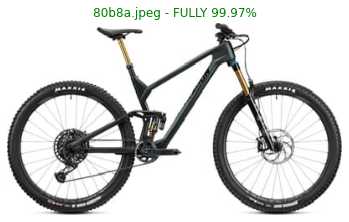

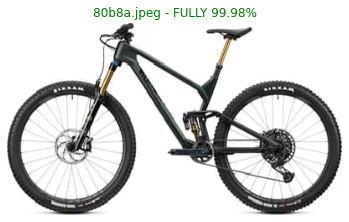

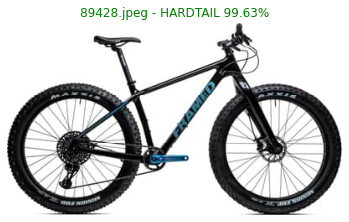

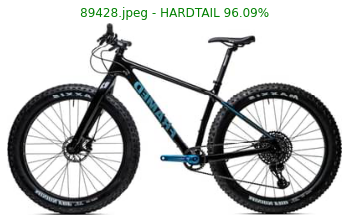

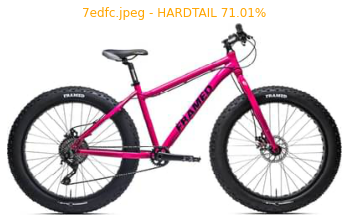

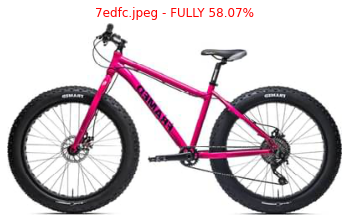

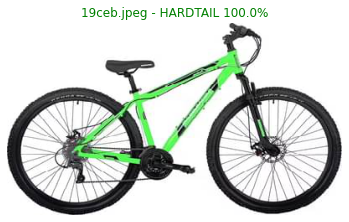

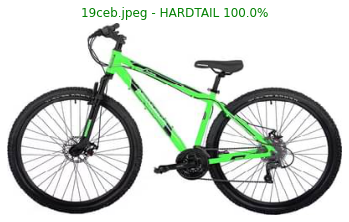

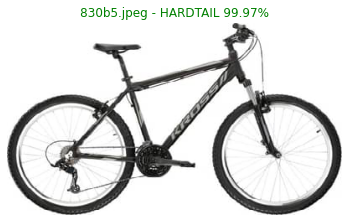

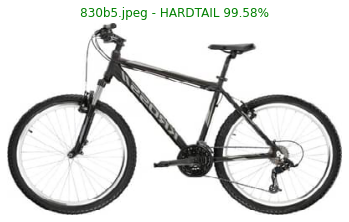

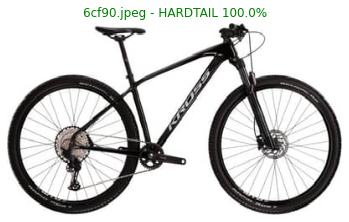

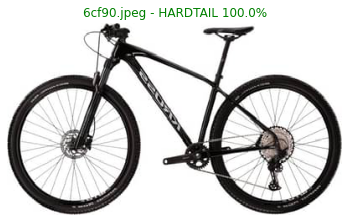

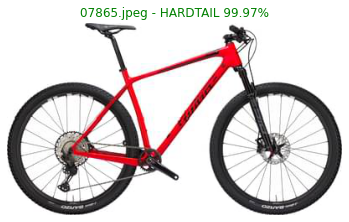

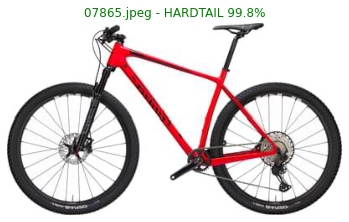

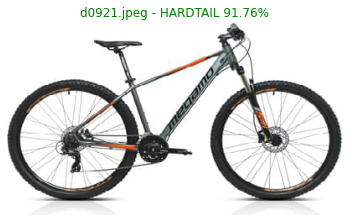

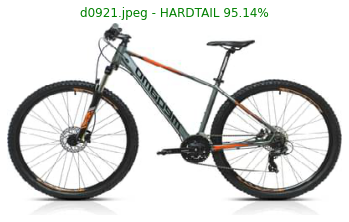

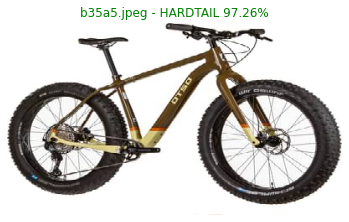

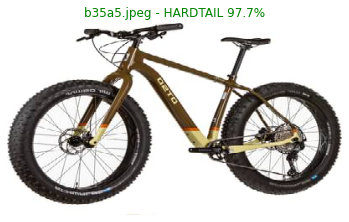

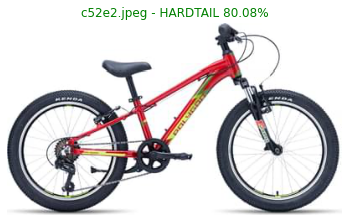

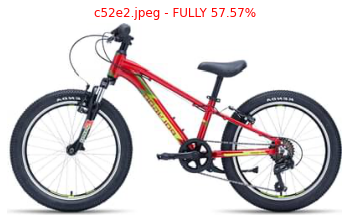

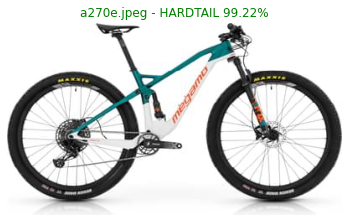

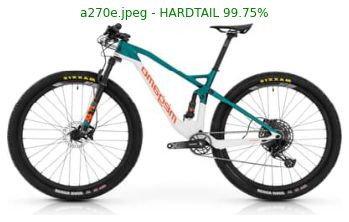

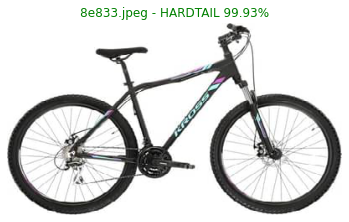

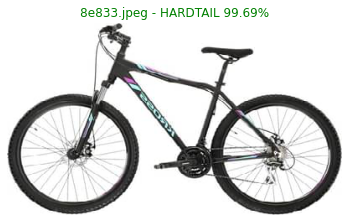

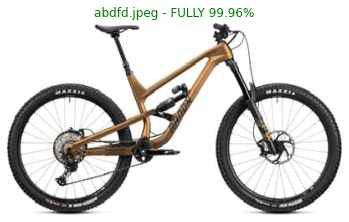

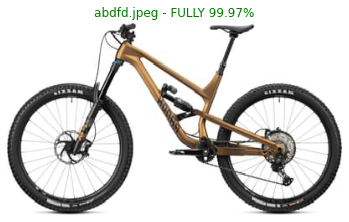

In [28]:
# predict all test images
for image_path in paths_to_test_images:
    predict_image(image_path);
    predict_image(image_path, mirrored=True);